#Predict whether the Tweet is a real Disaster or Not?
#Target = 1 means Real Disaster Tweet or else Target =0 Not Real Disaster Tweet

In [ ]:
!pip install category_encoders

     |████████████████████████████████| 81kB 3.6MB/s 


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re,string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import category_encoders as ce
import nltk
from nltk import word_tokenize
from sklearn.model_selection import train_test_split,GridSearchCV,KFold,StratifiedKFold
from sklearn.metrics import f1_score,accuracy_score,confusion_matrix
from nltk import FreqDist,bigrams
from wordcloud import STOPWORDS
from wordcloud import WordCloud
from sklearn.feature_selection import RFECV
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [ ]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
(train.isna().mean()*100)

id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64

In [ ]:
test.isna().mean()*100

id           0.000000
keyword      0.796813
location    33.864542
text         0.000000
dtype: float64

* so 33% of location values and around 8% of keyword values are missing in both test and train

In [ ]:
train.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [ ]:
train.duplicated().sum()

0

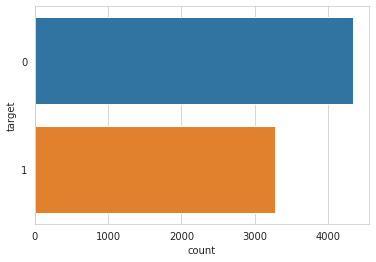

In [ ]:
sns.countplot(y=train.target)
plt.show()

In [ ]:
train[~train.keyword.isnull()]

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
...,...,...,...,...,...
7578,10830,wrecked,NaN,@jt_ruff23 @cameronhacker and I wrecked you both,0
7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0
7580,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0
7581,10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Li...,0


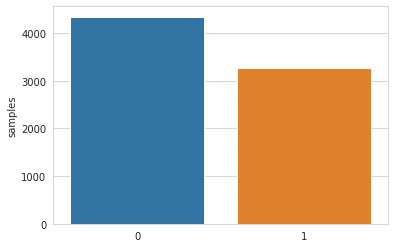

In [ ]:
x=train.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')
plt.show()

In [ ]:
train.keyword.nunique()-test.keyword.nunique()

0

In [ ]:
kw=train.keyword.value_counts()[:20]
kw

fatalities     45
armageddon     42
deluge         42
harm           41
sinking        41
damage         41
body%20bags    41
twister        40
windstorm      40
evacuate       40
siren          40
collided       40
outbreak       40
fear           40
whirlwind      39
sinkhole       39
wrecked        39
sunk           39
explosion      39
flames         39
Name: keyword, dtype: int64

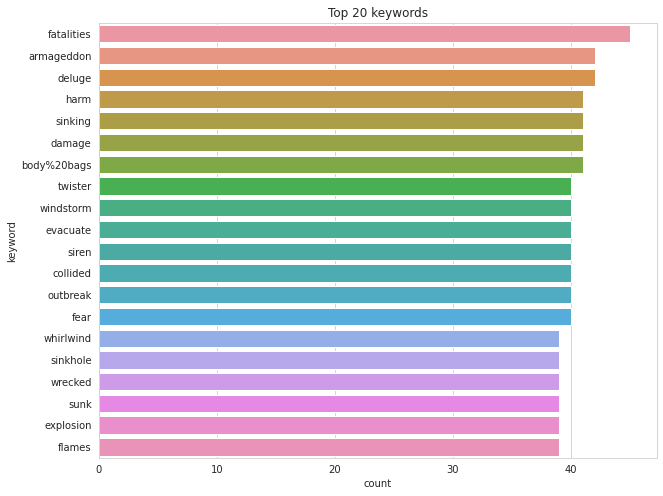

In [ ]:
plt.figure(figsize=(10,8))
sns.countplot(y=train.keyword,order=kw.index)
plt.title('Top 20 keywords')
plt.show()

In [ ]:
disaster_keyword=train[train.target==1]['keyword'].value_counts()[:20]
nonDisaster_keyword=train[train.target==0].keyword.value_counts()[:20]

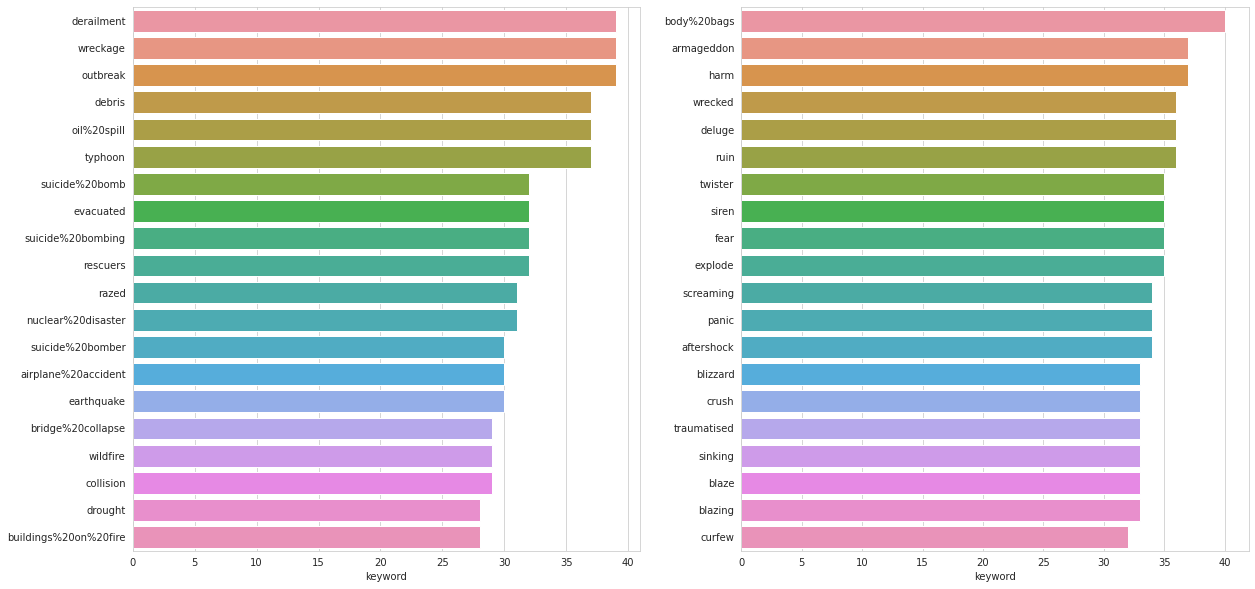

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(121)
sns.barplot(disaster_keyword,disaster_keyword.index)
plt.subplot(122)
sns.barplot(nonDisaster_keyword,nonDisaster_keyword.index)

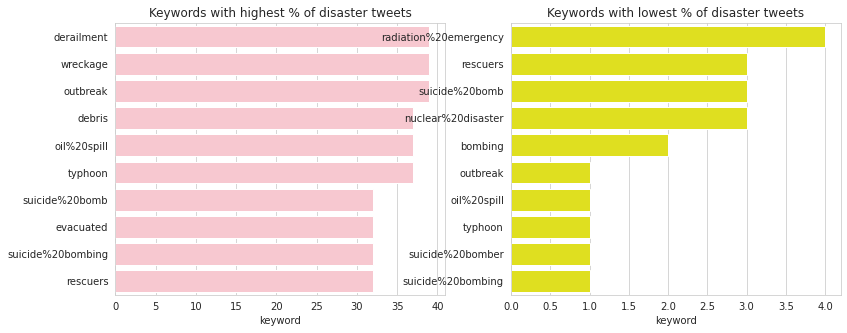

In [ ]:
top_d=train[train.target==1]['keyword'].value_counts()[:10]
top_nd=train[train.target==0].keyword.value_counts()[-10:]
plt.figure(figsize=(13,5))
plt.subplot(121)
sns.barplot(top_d, top_d.index, color='pink')
plt.title('Keywords with highest % of disaster tweets')
plt.subplot(122)
sns.barplot(top_nd, top_nd.index, color='yellow')
plt.title('Keywords with lowest % of disaster tweets')
plt.show()

## Data Cleaning & Creating Seperate Hashtags , Mentions and Links

In [ ]:
def clean_text(text):
  text=re.sub(r'\n',' ',text)
  text=re.sub(r'\s+',' ',text)
  text=re.sub(r'https?://\S+','',text)
  return text

def get_mentions(text):
  return ' '.join([match.group(0)[1:] for match in re.finditer(r'@\w+',text)]) or 'none'  
def get_hashtags(text):
  return ' '.join([match.group(0)[1:] for match in re.finditer(r'#\w+',text)]) or 'none' 
def get_links(text):
  return ' '.join([match.group(0) for match in re.finditer(r'https?://\S+',text)]) or 'none'       

In [ ]:
def process_df(df):
  df['mentions']=df.text.apply(get_mentions)
  df['hashtags']=df.text.apply(get_hashtags)
  df['links']=df.text.apply(get_links)
  df['clean_text']=df.text.apply(clean_text)
  return df

In [ ]:
train=process_df(train)
test=process_df(test)

In [ ]:
train.head()

,id,keyword,location,text,target,mentions,hashtags,links,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,none,earthquake,none,Our Deeds are the Reason of this #earthquake M...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,none,none,none,Forest fire near La Ronge Sask. Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,none,none,none,All residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,none,wildfires,none,"13,000 people receive #wildfires evacuation or..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,none,Alaska wildfires,none,Just got sent this photo from Ruby #Alaska as ...


In [ ]:
# https://stackoverflow.com/a/47091490/4084039
def decontracted(phrase):
 phrase = re.sub(r"won't", "will not", phrase)
 phrase = re.sub(r"can\'t", "can not", phrase)
 # general
 phrase = re.sub(r"n\'t", " not", phrase)
 phrase = re.sub(r"\'re", " are", phrase)
 phrase = re.sub(r"\'s", " is", phrase)
 phrase = re.sub(r"\'d", " would", phrase)
 phrase = re.sub(r"\'ll", " will", phrase)
 phrase = re.sub(r"\'t", " not", phrase)
 phrase = re.sub(r"\'ve", " have", phrase)
 phrase = re.sub(r"\'m", " am", phrase)
 return phrase
def preprocess(Input_Text):
  Input_Text=Input_Text.lower()
  Input_Text=re.sub(r"<[^>]*>",' ',Input_Text) #any html tags
  Input_Text=re.sub(r'(\().*?(\))',' ',Input_Text) #brackets removal
  Input_Text= re.sub('[^A-Za-z0-9]+', ' ', Input_Text) #punctuation removal 
  Input_Text=decontracted(Input_Text)
  Input_Text =''.join([i for i in Input_Text if not i.isdigit()]) 
  Input_Text=' '.join([i for i in Input_Text.split() if i.isalpha()])

  return Input_Text

In [ ]:
preprocess(train.clean_text.iloc[1])

'forest fire near la ronge sask canada'

In [ ]:
train['fully_cleaned']=train.clean_text.apply(lambda x: preprocess(x))

In [ ]:
test['fully_cleaned']=test.clean_text.apply(lambda x: preprocess(x))

In [ ]:
train.head()

,id,keyword,location,text,target,mentions,hashtags,links,clean_text,fully_cleaned
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,none,earthquake,none,Our Deeds are the Reason of this #earthquake M...,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,none,none,none,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,none,none,none,All residents asked to 'shelter in place' are ...,all residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,none,wildfires,none,"13,000 people receive #wildfires evacuation or...",people receive wildfires evacuation orders in ...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,none,Alaska wildfires,none,Just got sent this photo from Ruby #Alaska as ...,just got sent this photo from ruby alaska as s...


#Feature Engineering

In [ ]:
def create_stat(df):
    # Tweet length
    df['text_len']=df.clean_text.apply(len)
    df['word_count']=df.clean_text.apply(lambda x:len(x.split()))
    df['stopword_count']=df.clean_text.apply(lambda x:len([i for i in str(x).lower().split() if x in STOPWORDS]))
    df['hashtag_count']=df.hashtags.apply(lambda x:len(x.split()))
    df['mention_count'] = df['mentions'].apply(lambda x: len(str(x).split()))
    # Punctuation count
    df['punctuation_count'] = df['clean_text'].apply(lambda x: len([i for i in x if i in string.punctuation]))
    df['link_count'] = df['links'].apply(lambda x: len(str(x).split()))
    df['caps_count']=df.clean_text.apply(lambda x: len([i for i in x if i.isupper()]))
    # Ratio of uppercase letters
    df['caps_ratio']=df['caps_count'] / df['text_len']

    return df

In [ ]:
train_data = create_stat(train)
test_data = create_stat(test)

print(train_data.shape, test_data.shape)

(7613, 19) (3263, 18)


In [ ]:
train_data.corr()['target'].sort_values()

mention_count       -0.049654
caps_ratio          -0.015365
punctuation_count   -0.012535
word_count           0.017081
link_count           0.020244
caps_count           0.027808
hashtag_count        0.032853
id                   0.060781
text_len             0.100721
target               1.000000
stopword_count            NaN
Name: target, dtype: float64

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


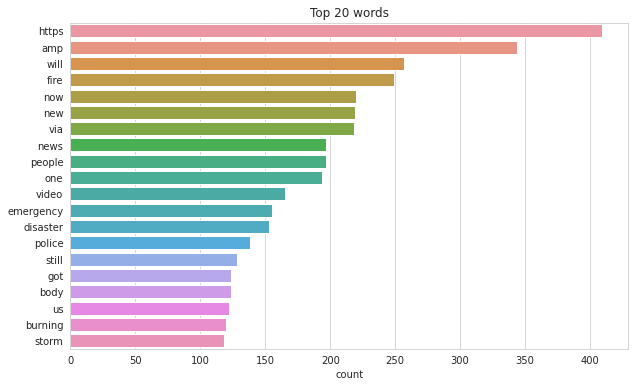

In [ ]:
"""
Most Frequent Words amnd Bigrams
"""
nltk.download('punkt')
stopwords=set(STOPWORDS)
word_freq=FreqDist(w for w in word_tokenize(' '.join(train.text).lower() )if w not in stopwords and (w.isalpha()))
df_word_freq=pd.DataFrame.from_dict(word_freq,columns=['count'],orient='index')
top20words=df_word_freq.sort_values('count',ascending=False).head(20)
plt.figure(figsize=(10,6))
sns.barplot(top20words['count'],top20words.index)
plt.title('Top 20 words')
plt.show()



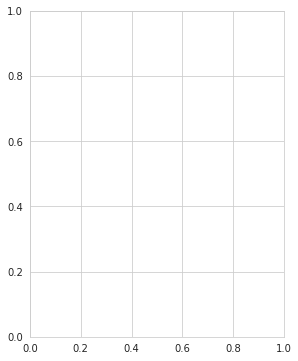

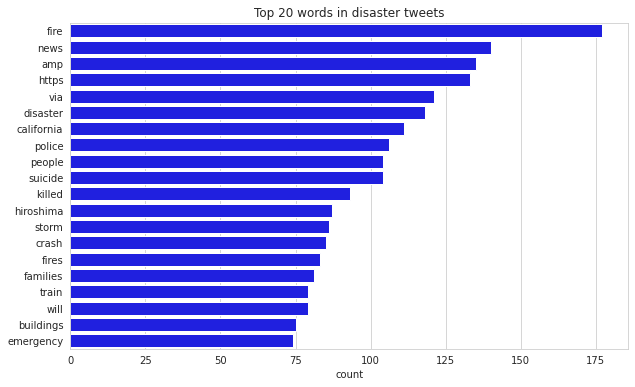

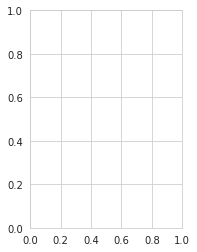

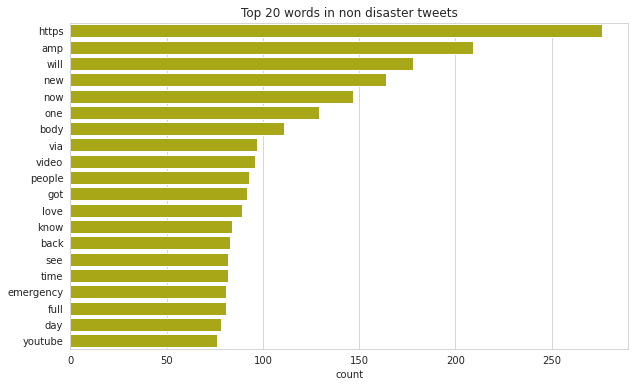

In [ ]:
"""
Most Frequent Words amnd Bigrams
"""
plt.figure(figsize=(10,6))
plt.tight_layout()
plt.subplot(1,2,1)
freq_pos=FreqDist(w for w in word_tokenize(' '.join(train.loc[train.target==1,'text']).lower() )if w not in stopwords and w.isalpha())
df_freq_pos=pd.DataFrame.from_dict(freq_pos,columns=['count'],orient='index')
top20words=df_freq_pos.sort_values('count',ascending=False).head(20)
plt.figure(figsize=(10,6))
sns.barplot(top20words['count'],top20words.index,color='b')
plt.title('Top 20 words in disaster tweets')
plt.show()
plt.tight_layout()
plt.subplot(1,2,2)
freq_neg=FreqDist(w for w in word_tokenize(' '.join(train.loc[train.target==0,'text']).lower() )if w not in stopwords and w.isalpha())
df_freq_neg=pd.DataFrame.from_dict(freq_neg,columns=['count'],orient='index')
top20words=df_freq_neg.sort_values('count',ascending=False).head(20)
plt.figure(figsize=(10,6))
sns.barplot(top20words['count'],top20words.index,color='y')
plt.title('Top 20 words in non disaster tweets')
plt.show()



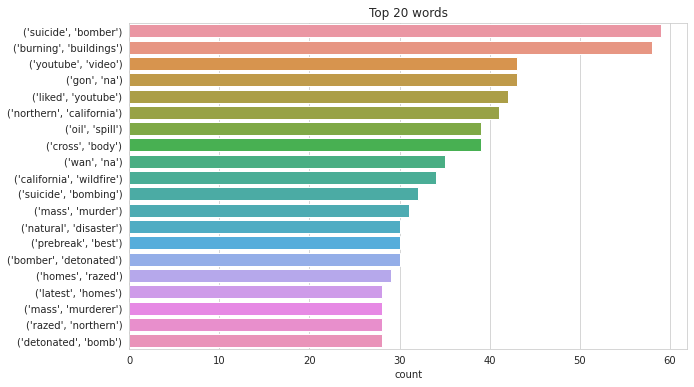

In [ ]:
#bigrams
bigrams1=bigrams(w for w in word_tokenize(' '.join(train.text).lower() )if w not in stopwords and (w.isalpha()))
word_freq=FreqDist([b for b in bigrams1])
df_word_freq=pd.DataFrame.from_dict(word_freq,columns=['count'],orient='index')
top20words=df_word_freq.sort_values('count',ascending=False).head(20)
plt.figure(figsize=(10,6))
sns.barplot(top20words['count'],top20words.index)
plt.title('Top 20 words')
plt.show()



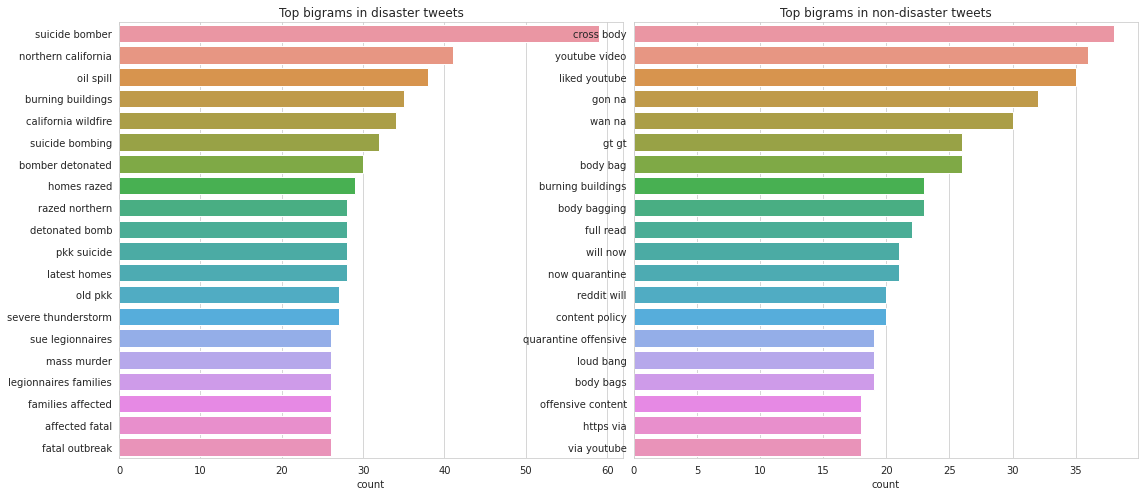

In [ ]:
# Bigrams

plt.figure(figsize=(16,7))
plt.tight_layout()
plt.subplot(1,2,1)
bigram_d = list(bigrams([w for w in word_tokenize(' '.join(train.loc[train.target==1, 'text']).lower()) if 
              (w not in stopwords) & (w.isalpha())]))
d_fq = FreqDist(bg for bg in bigram_d)
bgdf_d = pd.DataFrame.from_dict(d_fq, orient='index', columns=['count'])
bgdf_d.index = bgdf_d.index.map(lambda x: ' '.join(x))
bgdf_d = bgdf_d.sort_values('count',ascending=False)
sns.barplot(bgdf_d.head(20)['count'], bgdf_d.index[:20])
plt.title('Top bigrams in disaster tweets')

plt.tight_layout()
plt.subplot(1,2,2)
bigram_nd = list(bigrams([w for w in word_tokenize(' '.join(train.loc[train.target==0, 'text']).lower()) if 
              (w not in stopwords) & (w.isalpha())]))
nd_fq = FreqDist(bg for bg in bigram_nd)
bgdf_nd = pd.DataFrame.from_dict(nd_fq, orient='index', columns=['count'])
bgdf_nd.index = bgdf_nd.index.map(lambda x: ' '.join(x))
bgdf_nd = bgdf_nd.sort_values('count',ascending=False)
sns.barplot(bgdf_nd.head(20)['count'], bgdf_nd.index[:20])
plt.title('Top bigrams in non-disaster tweets')
plt.show()

## Analyse Missing values

In [ ]:
train.isna().sum()

id                      0
keyword                61
location             2533
text                    0
target                  0
mentions                0
hashtags                0
links                   0
clean_text              0
fully_cleaned           0
text_len                0
word_count              0
stopword_count          0
hashtag_count           0
mention_count           0
punctuation_count       0
link_count              0
caps_count              0
caps_ratio              0
dtype: int64

In [ ]:
train.keyword.value_counts()

fatalities               45
armageddon               42
deluge                   42
harm                     41
sinking                  41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [ ]:
train.keyword.unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

There is '%20' in some keywords .let us remove it

In [ ]:
train.keyword=train.keyword.str.replace('%20','_')

In [ ]:
train.keyword.unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane_accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew_up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown_up', 'body_bag', 'body_bagging', 'body_bags',
       'bomb', 'bombed', 'bombing', 'bridge_collapse',
       'buildings_burning', 'buildings_on_fire', 'burned', 'burning',
       'burning_buildings', 'bush_fires', 'casualties', 'casualty',
       'catastrophe', 'catastrophic', 'chemical_emergency', 'cliff_fall',
       'collapse', 'collapsed', 'collide', 'collided', 'collision',
       'crash', 'crashed', 'crush', 'crushed', 'curfew', 'cyclone',
       'damage', 'danger', 'dead', 'death', 'deaths', 'debris', 'deluge',
       'deluged', 'demolish', 'demolished', 'demolition', 'derail',
       'derailed', 'derailment', 'desol

In [ ]:
test.keyword=test.keyword.str.replace('%20','_')

In [ ]:
train.location.value_counts()

USA                                 104
New York                             71
United States                        50
London                               45
Canada                               29
                                   ... 
Reading UK                            1
#EngleWood CHICAGO                    1
Salt Lake City, Utah                  1
Bandar Lampung, Indonesia             1
Center for Domestic Preparedness      1
Name: location, Length: 3341, dtype: int64

Since some of the locations are repeated, this will require some bit of cleaning.


In [ ]:
# Replacing the ambigious locations name with Standard names
for i in [train,test]:
  i['location'].replace({'United States':'USA',
                           'New York':'USA',
                            "London":'UK',
                            "Los Angeles, CA":'USA',
                            "Washington, D.C.":'USA',
                            "California":'USA',
                             "Chicago, IL":'USA',
                             "Chicago":'USA',
                            "New York, NY":'USA',
                            "California, USA":'USA',
                            "FLorida":'USA',
                            "Nigeria":'Africa',
                            "Kenya":'Africa',
                            "Everywhere":'Worldwide',
                            "San Francisco":'USA',
                            "Florida":'USA',
                            "United Kingdom":'UK',
                            "Los Angeles":'USA',
                            "Toronto":'Canada',
                            "San Francisco, CA":'USA',
                            "NYC":'USA',
                            "Seattle":'USA',
                            "Earth":'Worldwide',
                            "Ireland":'UK',
                            "London, England":'UK',
                            "New York City":'USA',
                            "Texas":'USA',
                            "London, UK":'UK',
                            "Atlanta, GA":'USA',
                            "Mumbai":"India",
                            "304":"US"},inplace=True)

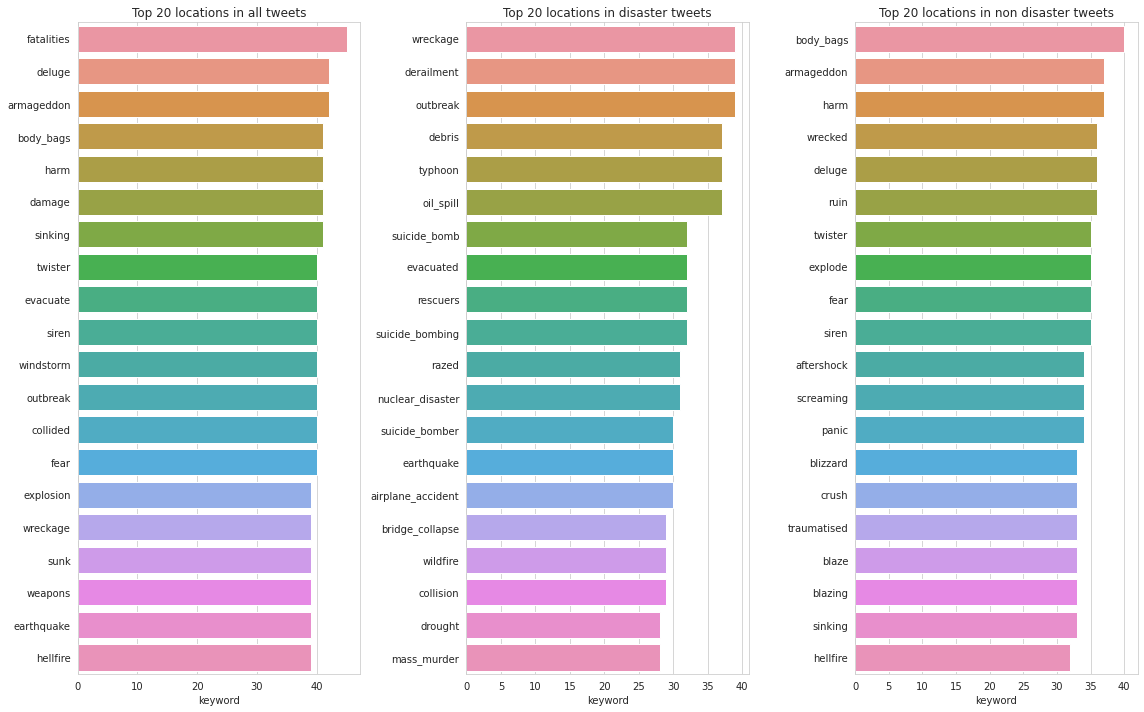

In [ ]:
plt.figure(figsize=(16,10))
plt.tight_layout()
plt.subplot(1,3,1)
plt.title("Top 20 locations in all tweets")
sns.barplot(y=train.keyword.value_counts()[:20].index,x=train.keyword.value_counts()[:20],orient='h')
plt.tight_layout()
plt.subplot(1,3,2)
plt.title("Top 20 locations in disaster tweets")
sns.barplot(y=train[train.target==1].keyword.value_counts()[:20].index,x=train[train.target==1].keyword.value_counts()[:20],orient='h')
plt.tight_layout()
plt.subplot(1,3,3)
plt.title("Top 20 locations in non disaster tweets")
sns.barplot(y=train[train.target==0].keyword.value_counts()[:20].index,x=train[train.target==0].keyword.value_counts()[:20],orient='h')
plt.show()


Observations

1) In whole training data 'fatalities' keyword is highly seen.

2) In disaster tweets,outbreak, wreckage,derailment these are most repeated keywords.

3) In non-disaster tweets,body%20bags is the most repeated keyword.


4) In disaster tweets, missing value will be filled by 'derailment' keyword.

5)In non-disaster tweets, missing value will be filled by 'body_bags' keyword.

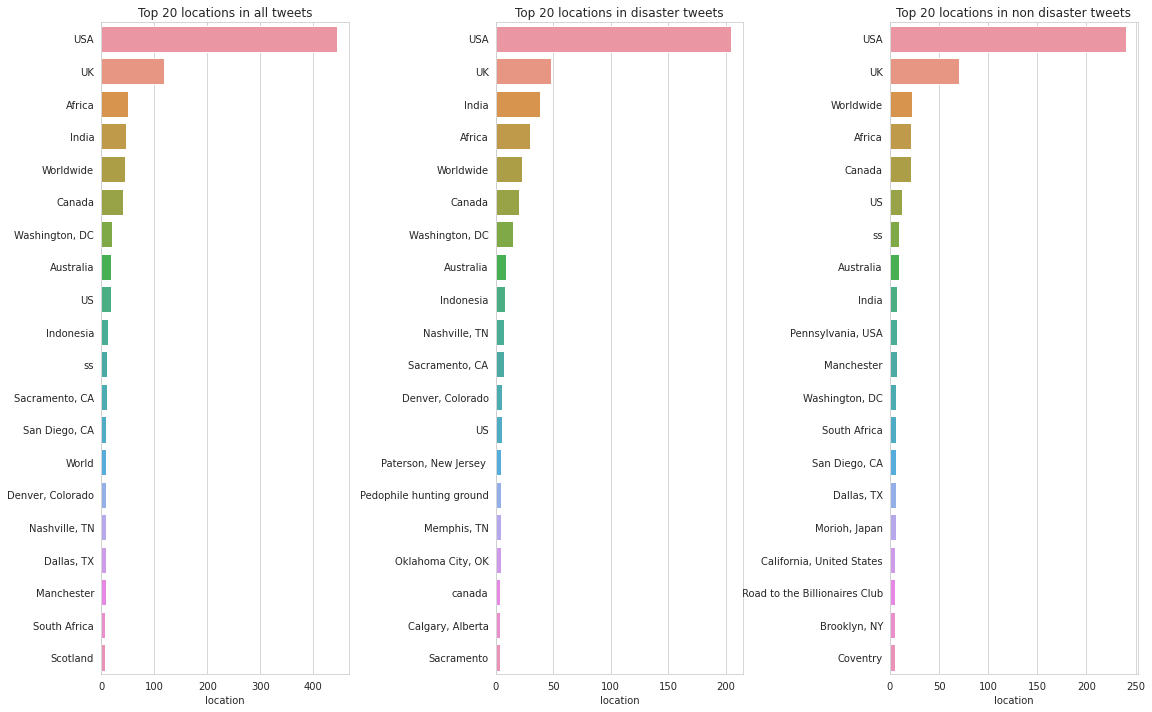

In [ ]:
plt.figure(figsize=(16,10))
plt.tight_layout()
plt.subplot(1,3,1)
plt.title("Top 20 locations in all tweets")
sns.barplot(y=train.location.value_counts()[:20].index,x=train.location.value_counts()[:20],orient='h')
plt.tight_layout()
plt.subplot(1,3,2)
plt.title("Top 20 locations in disaster tweets")
sns.barplot(y=train[train.target==1].location.value_counts()[:20].index,x=train[train.target==1].location.value_counts()[:20],orient='h')
plt.tight_layout()
plt.subplot(1,3,3)
plt.title("Top 20 locations in non disaster tweets")
sns.barplot(y=train[train.target==0].location.value_counts()[:20].index,x=train[train.target==0].location.value_counts()[:20],orient='h')
plt.show()

* In whole training data, Highly repeated locations are USA and UK where USA is repeated more than 400 times and UK is repeated more than 100 times in train dataset.

* In disaster and non-disaster tweets,USA is repeated more than 200 times.

* In disaster and non-disaster tweets, missing values will be filled by 'USA' location.

In [ ]:
dis_tweets=train[train.target==1]
non_dis_tweets=train[train.target==0]
dis_tweets.keyword.fillna('wreckage',inplace=True)
non_dis_tweets.keyword.fillna('body_bags',inplace=True)

In [ ]:
test.keyword.fillna('body_bags',inplace=True)

In [ ]:
train=pd.concat([dis_tweets,non_dis_tweets])

In [ ]:
train['location'].fillna('USA',inplace = True)
test['location'].fillna('USA',inplace = True)


## Exploring the 'text' column

In [ ]:
#https://www.kaggle.com/ekhtiar/unintended-eda-with-tutorial-notes
from wordcloud import WordCloud
def generate_word_cloud(identity, disaster_tweets, non_disaster_tweets):
  # convert stop words to sets as required by the wordcloud library
  
  wc_toxic=WordCloud(stopwords=stopwords,max_font_size=100,max_words=100,background_color='black').generate(str(disaster_tweets))
  wc_nontoxic=WordCloud(stopwords=stopwords,max_font_size=100,max_words=100,background_color='black').generate(str(non_disaster_tweets))
  # draw the two wordclouds side by side using subplot
  fig = plt.figure(figsize=[15,8])
  fig.add_subplot(1,2,1).set_title("disaster_tweets Wordcloud", fontsize=26)
  plt.imshow(wc_toxic,interpolation='bilinear')
  plt.axis('off')
  fig.add_subplot(1,2,2).set_title("non disaster_tweets Wordcloud", fontsize=26)
  plt.imshow(wc_nontoxic,interpolation='bilinear')
  plt.axis('off')
  plt.subplots_adjust(top=0.85)
  plt.suptitle('Word Cloud - {} Feature'.format(identity), size = 26)
  plt.show()

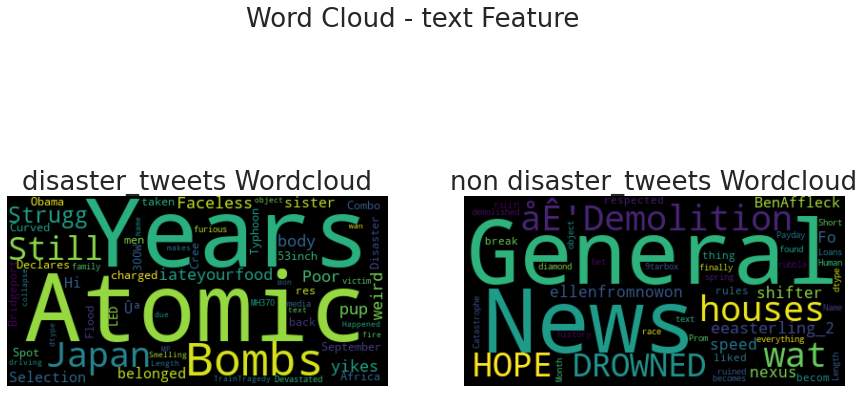

In [ ]:
generate_word_cloud('text',train[train.target==1]['text'].sample(3000),train[train.target==0]['text'].sample(4000))

Observations:

* In disaster text,more frequent words are accident ,Latest 
* In non_disaster text,more frequent words are Burned,sister


Count number of positive and negative words in each comment

https://gist.github.com/mkulakowski2/4289441 

https://gist.github.com/mkulakowski2/4289437

In [ ]:
from tqdm.notebook import tqdm
tqdm.pandas()
from textblob import TextBlob, Word, Blobber

In [ ]:
pos_path='./positive-words.txt'
neg_path='./negative-words.txt'
def load_file(path):
  fp=open(path,'r')
  all_lines=fp.readlines()
  words_list=[]
  for line in all_lines:
    words_list.append(line.strip())
  fp.close()
  return words_list

pos_words=load_file(pos_path)
neg_words=load_file(neg_path)  

#count  number of positive and negative words in each tweet
def pos_word_count(comment):
  count=0
  for i in comment.split():
    if i in pos_words:
      count+=1
  return count    
def neg_word_count(comment):
  count=0
  for i in comment.split():
    if i in neg_words:
      count+=1
  return count    

In [ ]:
train['pos_word_count']=train.clean_text.apply(pos_word_count)
train['neg_word_count']=train.clean_text.apply(neg_word_count)
test['pos_word_count']=test.clean_text.apply(pos_word_count)
test['neg_word_count']=test.clean_text.apply(neg_word_count)

## Find the sentiment of each comment

In [ ]:
TextBlob(train.clean_text.iloc[1]).sentiment[0]

0.1

In [ ]:
#https://www.pluralsight.com/guides/natural-language-processing-extracting-sentiment-from-text-data

%%time
sentiment_count=[]
for i in train.clean_text.values:
  sentiment_count.append(TextBlob(i).sentiment[0])
train['sentiment']=sentiment_count  
sentiment_count=[]
for i in test.clean_text.values:
  sentiment_count.append(TextBlob(i).sentiment[0])  
test['sentiment']=sentiment_count

CPU times: user 4.59 s, sys: 1.07 ms, total: 4.59 s
Wall time: 4.59 s


## Univariate Analysis: word_count feature

<Figure size 936x576 with 0 Axes>

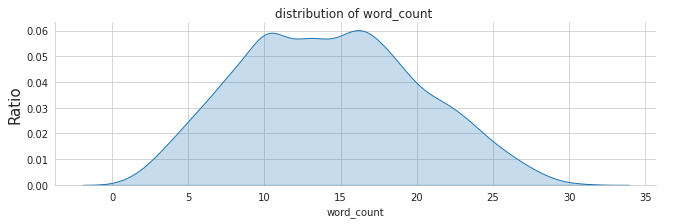

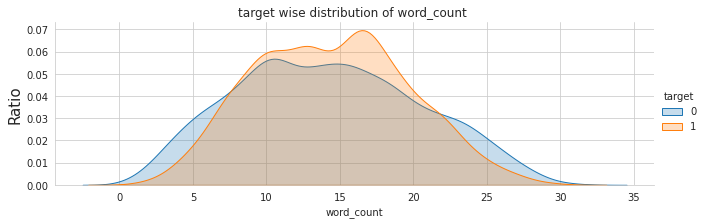

In [ ]:
plt.figure(figsize=(13,8))
sns.FacetGrid(train,aspect=3).map(sns.kdeplot,'word_count',shade=True).add_legend()
plt.title('distribution of word_count ')
plt.ylabel('Ratio',fontsize=15) 
sns.FacetGrid(train,hue='target',aspect=3).map(sns.kdeplot,'word_count',shade=True).add_legend()
plt.title('target wise distribution of word_count ')
plt.ylabel('Ratio',fontsize=15) 
plt.show()

Observation :

1)Many tweets are with word count of 8-13.

2) Distribution of disaster tweets is peaked than distribution of non-disaster tweets.

3)Distribution of both classes is overlapping.

## Univariate Analysis: text_len feature

<Figure size 936x576 with 0 Axes>

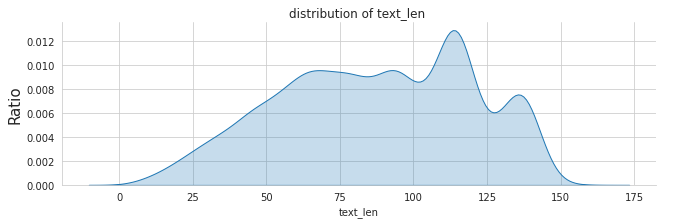

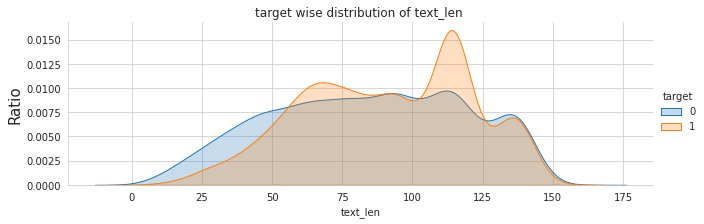

In [ ]:
plt.figure(figsize=(13,8))
sns.FacetGrid(train,aspect=3).map(sns.kdeplot,'text_len',shade=True).add_legend()
plt.title('distribution of text_len ')
plt.ylabel('Ratio',fontsize=15) 
sns.FacetGrid(train,hue='target',aspect=3).map(sns.kdeplot,'text_len',shade=True).add_legend()
plt.title('target wise distribution of text_len ')
plt.ylabel('Ratio',fontsize=15) 
plt.show()


Observation :

1)Many tweets are with char count of 75-85.

2) Distribution of disaster tweets is peaked than distribution of non-disaster tweets.

3)Distribution of both classes is overlapping.

## Univariate Analysis: caps_count feature

<Figure size 936x576 with 0 Axes>

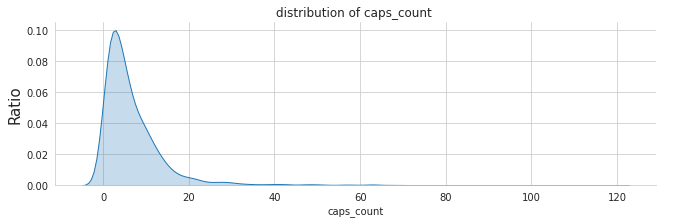

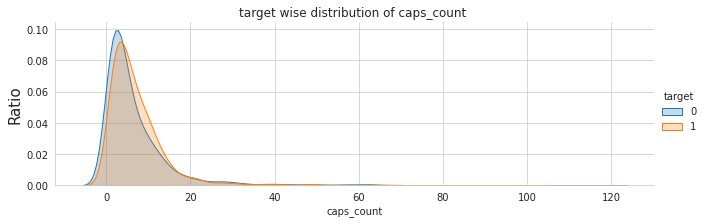

In [ ]:
plt.figure(figsize=(13,8))
sns.FacetGrid(train,aspect=3).map(sns.kdeplot,'caps_count',shade=True).add_legend()
plt.title('distribution of caps_count ')
plt.ylabel('Ratio',fontsize=15) 
sns.FacetGrid(train,hue='target',aspect=3).map(sns.kdeplot,'caps_count',shade=True).add_legend()
plt.title('target wise distribution of caps_count ')
plt.ylabel('Ratio',fontsize=15) 
plt.show()

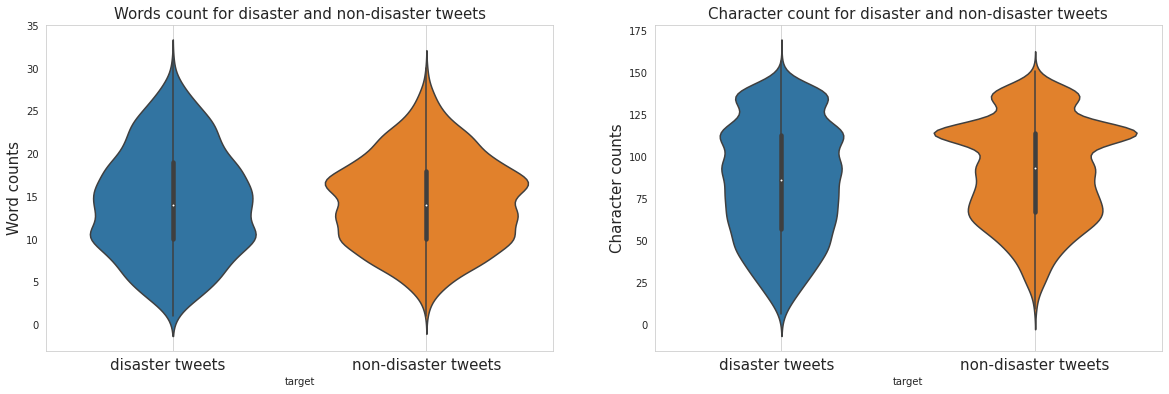

In [ ]:
#getting violin plot on train data with word_count feature
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
sns.violinplot(x = 'target', y = 'word_count', data = train[0:])
plt.xticks([0,1],('disaster tweets  ','non-disaster tweets'), fontsize=15) 
plt.ylabel('Word counts', fontsize=15) 
plt.title('Words count for disaster and non-disaster tweets', fontsize=15) 
plt.grid() 

plt.subplot(1,2,2)
sns.violinplot(x = 'target', y = 'text_len', data = train[0:])
plt.xticks([0,1],('disaster tweets  ','non-disaster tweets'), fontsize=15) 
plt.ylabel('Character counts',fontsize=15) 
plt.title('Character count for disaster and non-disaster tweets', fontsize=15) 
plt.grid()


#Observation

This plot giving more clear picture than distribution plot. For Disaster tweets word count distribution is flattened at count 9-13 and In character count distribution is flattened at count 75-90.

For non-disaster tweets word count distribution is peaked at count 12 and In character count distribution is flattened at count 85.

Average word count of disaster tweets is 10 and for non-disaster tweets its 12.

Average char count of disaster tweets is 65 and for non-disaster tweets its 75.

Distributions of disaster and non-disaster tweets are almost same

<Figure size 936x576 with 0 Axes>

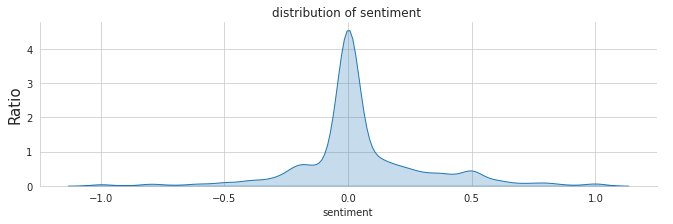

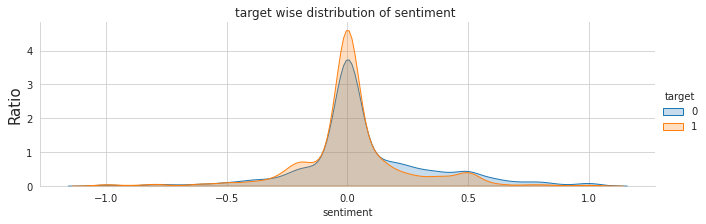

In [ ]:
plt.figure(figsize=(13,8))
sns.FacetGrid(train,aspect=3).map(sns.kdeplot,'sentiment',shade=True).add_legend()
plt.title('distribution of sentiment ')
plt.ylabel('Ratio',fontsize=15) 
sns.FacetGrid(train,hue='target',aspect=3).map(sns.kdeplot,'sentiment',shade=True).add_legend()
plt.title('target wise distribution of sentiment ')
plt.ylabel('Ratio',fontsize=15) 
plt.show()

#Observation:

1) More than 90% data is neutral.

2) Most of the neutral tweets are from disaster category.

3)Neutrality ratio of non-disaster tweets are half of the disaster tweets.

## Univariate Analysis: positive and negative words count of each comment

In [ ]:
train.pos_word_count.value_counts()

0    6218
1    1170
2     190
3      30
4       5
Name: pos_word_count, dtype: int64

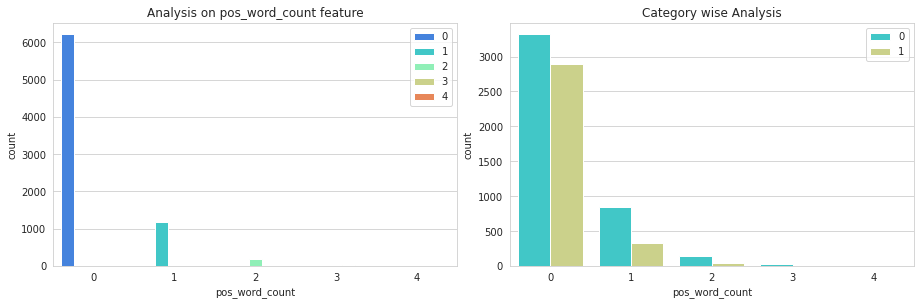

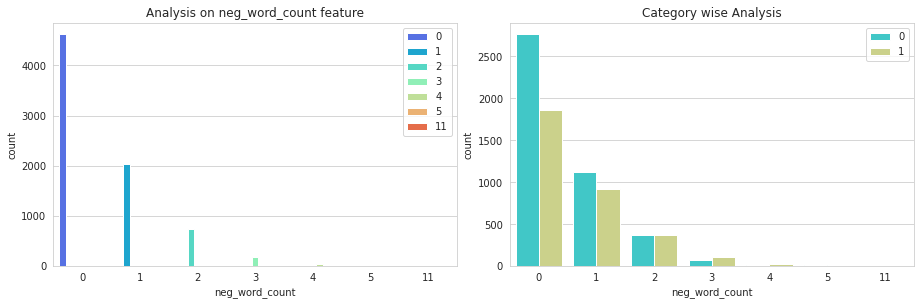

In [ ]:
cat_cols=['pos_word_count','neg_word_count']
for col in cat_cols:
  plt.figure(figsize=(13,8))
  plt.tight_layout(h_pad=2,w_pad=3)
  plt.subplot(2,2,1)
  plt.tight_layout(h_pad=2,w_pad=3)
  sns.set_style('whitegrid')
  plt.title("Analysis on {0} feature".format(col))
  sns.countplot(x=col,hue=col,data=train,palette='rainbow')
  plt.legend(loc=1)

  plt.subplot(2,2,2)
  plt.tight_layout(h_pad=2,w_pad=3)
  sns.set_style('whitegrid')
  plt.title("Category wise Analysis".format(col))
  sns.countplot(x=col,hue='target',data=train,palette='rainbow')
  plt.legend(loc=1)

# Observation:

pos_word_count Feature:

1)Here tweets with 0 positive words are more and some tweets included with 1 or 2 positive words.
neg_word_count Feature:

1)Here tweets with 0 or 1 negative words are more and some tweets included with 2-4 negative words.

## Encoding categorical feature : keyword

In [ ]:
vec=CountVectorizer(min_df=5)
key_vec=vec.fit_transform(train.keyword)
X_train_key=pd.DataFrame(key_vec.toarray(),columns=vec.get_feature_names())
key_vec_t=vec.transform(test.keyword)
X_test_key=pd.DataFrame(key_vec_t.toarray(),columns=vec.get_feature_names())
X_train_key.head()

,ablaze,accident,aftershock,airplane_accident,ambulance,annihilated,annihilation,apocalypse,armageddon,army,arson,arsonist,attack,attacked,avalanche,battle,bioterror,bioterrorism,blaze,blazing,bleeding,blew_up,blight,blizzard,blood,bloody,blown_up,body_bag,body_bagging,body_bags,bomb,bombed,bombing,bridge_collapse,buildings_burning,buildings_on_fire,burned,burning,burning_buildings,bush_fires,...,snowstorm,storm,stretcher,structural_failure,suicide_bomb,suicide_bomber,suicide_bombing,sunk,survive,survived,survivors,terrorism,terrorist,threat,thunder,thunderstorm,tornado,tragedy,trapped,trauma,traumatised,trouble,tsunami,twister,typhoon,upheaval,violent_storm,volcano,war_zone,weapon,weapons,whirlwind,wild_fires,wildfire,windstorm,wounded,wounds,wreck,wreckage,wrecked
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
vec=CountVectorizer(min_df=5)
men_vec=vec.fit_transform(train.mentions)
X_train_men=pd.DataFrame(men_vec.toarray(),columns=vec.get_feature_names())
men_vec_t=vec.transform(test.mentions)
X_test_men=pd.DataFrame(men_vec_t.toarray(),columns=vec.get_feature_names())
X_train_men.head()

,ap,arianagrande,change,djicemoon,emmerdale,foxnews,invalid,justinbieber,mikeparractor,none,potus,stretcher,towel,usagov,usatoday,viralspell,youngheroesid,youtube
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [ ]:
vec=CountVectorizer(min_df=5)
hash_vec=vec.fit_transform(train.hashtags)
X_train_hash=pd.DataFrame(hash_vec.toarray(),columns=vec.get_feature_names())
hash_vec_t=vec.transform(test.hashtags)
X_test_hash=pd.DataFrame(hash_vec_t.toarray(),columns=vec.get_feature_names())
X_train_hash.head()

,abstorm,africa,afterlife,allah,animalrescue,antioch,armageddon,art,bb17,bbc,best,bestnaijamade,beyhive,breaking,business,california,cnn,course,dance,directioners,disaster,dnb,drought,dubstep,earthquake,edm,emergency,emmerdale,fashion,fukushima,gbbo,genocide,god,hailstorm,handbag,hiring,hiroshima,hot,ices,india,...,pantherattack,phoenix,photography,prebreak,preparedness,prophetmuhammad,quote,quran,refugees,rohingya,rt,science,seattle,sismo,sittwe,socialnews,somalia,soundcloud,strategicpatience,summerfate,tbt,tcot,tech,technology,terrorism,trapmusic,truth,tubestrike,uk,us,usa,usgs,wildfire,wildfires,wmata,womens,world,worldnews,wx,yyc
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
vec=CountVectorizer(min_df=5,analyzer='word',token_pattern=r'https?://\S+')
links_vec=vec.fit_transform(train.links)
X_train_link=pd.DataFrame(links_vec.toarray(),columns=vec.get_feature_names())
links_vec_t=vec.transform(test.links)
X_test_link=pd.DataFrame(links_vec_t.toarray(),columns=vec.get_feature_names())
X_train_link.head()

,http://t.co/cybksxhf7d,http://t.co/encmhz6y34,http://t.co/ksawlyux02,http://t.co/q2eblokeve,http://t.co/qew4c5m1xd,http://t.co/vvplfqv58p
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


In [ ]:
train.head()

,id,keyword,location,text,target,mentions,hashtags,links,clean_text,fully_cleaned,text_len,word_count,stopword_count,hashtag_count,mention_count,punctuation_count,link_count,caps_count,caps_ratio,pos_word_count,neg_word_count,sentiment
0,1,wreckage,USA,Our Deeds are the Reason of this #earthquake M...,1,none,earthquake,none,Our Deeds are the Reason of this #earthquake M...,our deeds are the reason of this earthquake ma...,69,13,0,1,1,1,1,10,0.144928,0,0,0.00000
1,4,wreckage,USA,Forest fire near La Ronge Sask. Canada,1,none,none,none,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada,38,7,0,1,1,1,1,5,0.131579,0,0,0.10000
2,5,wreckage,USA,All residents asked to 'shelter in place' are ...,1,none,none,none,All residents asked to 'shelter in place' are ...,all residents asked to shelter in place are be...,133,22,0,1,1,3,1,2,0.015038,0,0,-0.01875
3,6,wreckage,USA,"13,000 people receive #wildfires evacuation or...",1,none,wildfires,none,"13,000 people receive #wildfires evacuation or...",people receive wildfires evacuation orders in ...,65,8,0,1,1,2,1,1,0.015385,0,0,0.00000
4,7,wreckage,USA,Just got sent this photo from Ruby #Alaska as ...,1,none,Alaska wildfires,none,Just got sent this photo from Ruby #Alaska as ...,just got sent this photo from ruby alaska as s...,88,16,0,2,1,2,1,3,0.034091,0,1,0.00000


## TF-IDF Vectoriser

In [ ]:
tfidf=TfidfVectorizer(min_df=10,ngram_range=(1,2),stop_words='english')
# Only include >=10 occurrences
# Have unigrams , bigrams,trigrams
text_vec=tfidf.fit_transform(train.clean_text)
X_train_text=pd.DataFrame(text_vec.toarray(),columns=tfidf.get_feature_names())
key_vec_t=tfidf.transform(test.clean_text)
X_test_text=pd.DataFrame(text_vec.toarray(),columns=tfidf.get_feature_names())
X_train_text.head()

,00,01,04,05,06,07,08,08 05,08 06,10,100,11,11 year,12,12000,12000 nigerian,13,130,130 specially,14,15,15 saudi,16,16yr,16yr old,17,18,1980,1st,20,2013,2014,2015,2015 prebreak,22,24,25,29,2nd,30,...,worth,wounded,wounded suspect,wounds,wow,wreck,wreckage,wreckage conclusively,wrecked,wrong,wrought,wtf,wwii,yeah,year,year old,years,years ago,years atomic,yes,yo,york,young,youth,youth saved,youtube,youtube playlist,youtube video,yyc,zone,û_,ûª,ûªs,ûªt,ûªve,ûï,ûïwhen,ûïwhen saw,ûò,ûó
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.440803,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
train=train.join(X_train_hash,rsuffix='_hashtag')
train=train.join(X_train_link,rsuffix='_link')
train=train.join(X_train_key,rsuffix='_key')
train=train.join(X_train_men,rsuffix='_men')
train=train.join(X_train_text,rsuffix='_text')
test=test.join(X_test_hash,rsuffix='_hashtag')
test=test.join(X_test_link,rsuffix='_link')
test=test.join(X_test_key,rsuffix='_key')
test=test.join(X_test_men,rsuffix='_men')
test=test.join(X_test_text,rsuffix='_text')

In [ ]:
train.shape,test.shape

((7613, 2065), (3263, 2064))

In [ ]:
train.head()

,id,keyword,location,text,target,mentions,hashtags,links,clean_text,fully_cleaned,text_len,word_count,stopword_count,hashtag_count,mention_count,punctuation_count,link_count,caps_count,caps_ratio,pos_word_count,neg_word_count,sentiment,abstorm,africa,afterlife,allah,animalrescue,antioch,armageddon,art,bb17,bbc,best,bestnaijamade,beyhive,breaking,business,california,cnn,course,...,worth,wounded_text,wounded suspect,wounds_text,wow,wreck_text,wreckage_text,wreckage conclusively,wrecked_text,wrong,wrought,wtf,wwii,yeah,year,year old,years,years ago,years atomic,yes,yo,york,young,youth,youth saved,youtube_text,youtube playlist,youtube video,yyc_text,zone,û_,ûª,ûªs,ûªt,ûªve,ûï,ûïwhen,ûïwhen saw,ûò,ûó
0,1,wreckage,USA,Our Deeds are the Reason of this #earthquake M...,1,none,earthquake,none,Our Deeds are the Reason of this #earthquake M...,our deeds are the reason of this earthquake ma...,69,13,0,1,1,1,1,10,0.144928,0,0,0.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4,wreckage,USA,Forest fire near La Ronge Sask. Canada,1,none,none,none,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada,38,7,0,1,1,1,1,5,0.131579,0,0,0.10000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,wreckage,USA,All residents asked to 'shelter in place' are ...,1,none,none,none,All residents asked to 'shelter in place' are ...,all residents asked to shelter in place are be...,133,22,0,1,1,3,1,2,0.015038,0,0,-0.01875,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6,wreckage,USA,"13,000 people receive #wildfires evacuation or...",1,none,wildfires,none,"13,000 people receive #wildfires evacuation or...",people receive wildfires evacuation orders in ...,65,8,0,1,1,2,1,1,0.015385,0,0,0.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7,wreckage,USA,Just got sent this photo from Ruby #Alaska as ...,1,none,Alaska wildfires,none,Just got sent this photo from Ruby #Alaska as ...,just got sent this photo from ruby alaska as s...,88,16,0,2,1,2,1,3,0.034091,0,1,0.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
features_to_drop = ['id', 'keyword','location','text','clean_text', 'hashtags','fully_cleaned', 'mentions','hashtags','links']
scaler=MinMaxScaler()
X_train=train.drop(columns=features_to_drop+['target'],axis=1)
X_test=test.drop(columns=features_to_drop,axis=1)
y_train=train.target
lr=LogisticRegression(solver='liblinear',random_state=95)# Other solvers have failure to converge problem

pipeline=Pipeline([('scaler',scaler),('lr',lr),])
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=95,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [ ]:
y_test = pipeline.predict(X_test)
submission=pd.read_csv('sample_submission.csv')
submit = submission.copy()
submit.target = y_test
submit.to_csv('submit_lr.csv',index=False)

In [ ]:
print('training accuacy',pipeline.score(X_train,y_train))

training accuacy 0.7791934848285826


In [ ]:
print('train f1 score',f1_score(y_train,pipeline.predict(X_train)))

train f1 score 0.72599837000815


In [ ]:
pd.DataFrame(confusion_matrix(y_train,pipeline.predict(X_train)))

,0,1
0,3705,637
1,1044,2227


## Model Evaluation

In [ ]:
#https://stackoverflow.com/questions/34731421/whats-the-difference-between-kfold-and-shufflesplit-cv
from sklearn.model_selection import cross_val_score,ShuffleSplit
cv=ShuffleSplit(n_splits=5,test_size=0.2,random_state=95)
cv_score=cross_val_score(pipeline,X_train,y_train,scoring='f1',cv=cv)
print('Cross validation F-1 score: %.3f' %np.mean(cv_score))


Cross validation F-1 score: 0.600


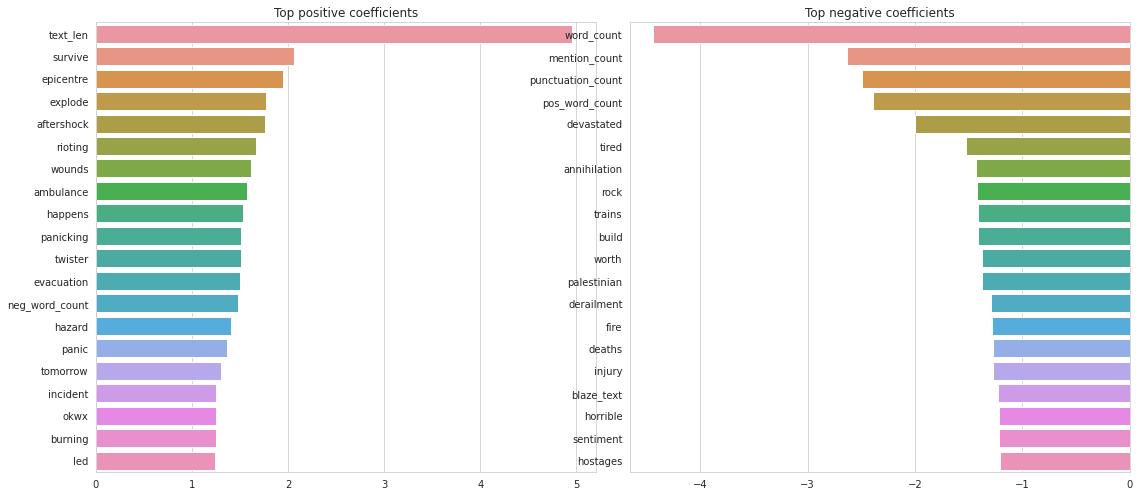

In [ ]:
"""
Feature Selection - Identifying the Top Features
"""
plt.figure(figsize=(16,7))
s1=pd.Series(np.transpose(lr.coef_[0]),index=X_train.columns).sort_values(ascending=False)[:20]
s2=pd.Series(np.transpose(lr.coef_[0]),index=X_train.columns).sort_values()[:20]
plt.subplot(121)
plt.tight_layout()
sns.barplot(y=s1.index,x=s1)
plt.title('Top positive coefficients')
plt.subplot(122)
plt.tight_layout()
sns.barplot(y=s2.index,x=s2)
plt.title('Top negative coefficients')
plt.show()



Findings:
'text_len' is the top positive coefficient, meaning the keyword column made a good feature hiroshima both as text and hashtag made the top 20 positive coefficients Punctuation count and  word_count are among top 20 negative coefficients None of the bigrams made the top features

In [ ]:

"""
step parameter in RFECV corresponds to the (integer) number of features to remove at each iteration.
"""

steps=10
rfecv=RFECV(lr,steps,scoring='f1',cv=cv)
p2=Pipeline([('scale',scaler),('rfecv',rfecv),])
p2.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('rfecv',
                 RFECV(cv=ShuffleSplit(n_splits=5, random_state=95, test_size=0.2, train_size=None),
                       estimator=LogisticRegression(C=1.0, class_weight=None,
                                                    dual=False,
                                                    fit_intercept=True,
                                                    intercept_scaling=1,
                                                    l1_ratio=None, max_iter=100,
                                                    multi_class='auto',
                                                    n_jobs=None, penalty='l2',
                                                    random_state=95,
                                                    solver='liblinear',
                                                    tol=0.0001, verbose=0,
                                          

In [ ]:

"""
RFECV exposes support_ which is another attribute to find out the features which contribute the most to predicting. 
In order to find out which features are selected we can use the following code.
"""
selected_features=X_train.columns[rfecv.support_==True]
X1=X_train[selected_features]
X2=X_test[selected_features]
X1.shape

(7613, 1015)

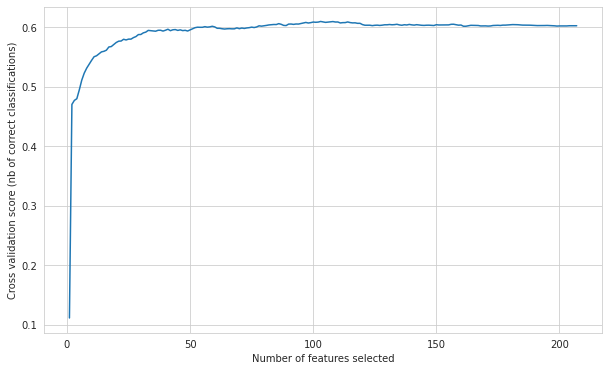

In [ ]:
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [ ]:
"""
Grid Search CV - Hyperparamater Tuning
"""

grid={"C":np.logspace(-2,2,5), "penalty":["l1","l2"]}
lr_cv = GridSearchCV(LogisticRegression(solver='liblinear', random_state=20), grid, cv=cv, scoring = 'f1')

pipeline_grid = Pipeline([('scale',scaler), ('gridsearch', lr_cv),])

pipeline_grid.fit(X1, y_train)

print("Best parameter: ", lr_cv.best_params_)
print("F-1 score: %.3f" %lr_cv.best_score_)

Best parameter:  {'C': 1.0, 'penalty': 'l2'}
F-1 score: 0.655


In [ ]:
y_test2 = pipeline_grid.predict(X2)
submit2 = submission.copy()
submit2.target = y_test2
submit2.to_csv('submit_lr2.csv',index=False)

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()


nb=GaussianNB()# Other solvers have failure to converge problem

pipeline3=Pipeline([('scaler',scaler),('nb',nb),])
pipeline3.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('nb', GaussianNB(priors=None, var_smoothing=1e-09))],
         verbose=False)

In [ ]:
y_test2 = pipeline3.predict(X_test)

submit2 = submission.copy()
submit2.target = y_test2
submit2.to_csv('submit_nb.csv',index=False)

In [ ]:
print('train f1 score',f1_score(y_train,pipeline3.predict(X_train)))
print('training accuacy',pipeline3.score(X_train,y_train))

train f1 score 0.680184331797235
training accuacy 0.6353605674504138


In [ ]:
#https://stackoverflow.com/questions/34731421/whats-the-difference-between-kfold-and-shufflesplit-cv
from sklearn.model_selection import cross_val_score,ShuffleSplit
cv=ShuffleSplit(n_splits=10,test_size=0.2,random_state=95)
cv_score2=cross_val_score(pipeline3,X_train,y_train,scoring='f1',cv=cv)
print('Cross validation F-1 score: %.3f' %np.mean(cv_score2))


Cross validation F-1 score: 0.612
